In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pickle
from keras.models import load_model

Using TensorFlow backend.


In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [7]:
train_df = pd.read_csv('./UCI HAR Dataset/train/train.csv')
test_df = pd.read_csv('./UCI HAR Dataset/test/test.csv')
train_df['activity'] -= 1;
test_df['activity'] -= 1;

y_train = train_df['activity']
X_train = train_df.drop(['activity','activity_name','subject_id'],axis=1)
y_test = test_df['activity']
X_test = test_df.drop(['activity','activity_name','subject_id'],axis=1)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [9]:
def results(clf, trainX, trainY ,X, y_true): 
    clf.fit(trainX, trainY.values.ravel())
    
    X_test_values = X
    y_predicted = clf.predict(X_test_values)
    print(classification_report(y_true, y_predicted))

    array = confusion_matrix(y_true, y_predicted)
    df_cm = pd.DataFrame(array, index = [i for i in LABELS],
                    columns = [i for i in LABELS])
#     plt.figure(figsize = (10,7))
#     sn.heatmap(df_cm, annot=True, cmap="BuPu",fmt='g')
    
   
    recall = metrics.recall_score(y_true, y_predicted, average='macro' )
    precision = metrics.precision_score(y_true, y_predicted, average='macro' )
    f_score = metrics.f1_score(y_true, y_predicted, average="macro") 
    acc = metrics.accuracy_score(y_true, y_predicted)
    
    print(round(recall,4) * 100, 'Recall')
    print(round(precision, 4)*100, 'pre')
    print(round(f_score, 4)*100, "fscore")
    print(round(acc, 4) *100, 'acc')

# Dimensionality Reduction

## PCA

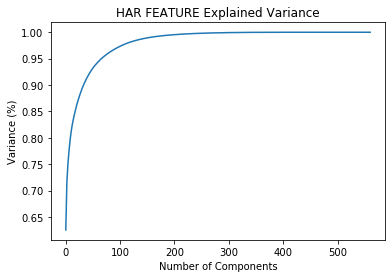

In [12]:
pca = PCA().fit(X_train)
n_pcs= pca.components_.shape[0]


most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]


temp = []
for  i in most_important:
    if i not in temp:
        temp.append(i)
        

most_important = temp

most_important = most_important[:200]



# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('HAR FEATURE Explained Variance')
plt.show()

In [13]:
X_train_pca = X_train.iloc[:,most_important]
X_test_pca = X_test.iloc[:,most_important]

### Models

In [14]:
#SVM

svm = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
results(svm, X_train_pca, y_train ,X_test_pca, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       496
           1       0.97      0.96      0.97       471
           2       0.98      0.95      0.97       420
           3       0.95      0.90      0.93       491
           4       0.92      0.96      0.94       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

96.13000000000001 Recall
96.28 pre
96.17999999999999 fscore
96.2 acc


In [20]:
#KNN

knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors = 15, weights = 'distance')
results(knn, X_train_pca, y_train ,X_test_pca, y_test)

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       496
           1       0.91      0.90      0.91       471
           2       0.98      0.84      0.91       420
           3       0.92      0.76      0.83       491
           4       0.81      0.95      0.87       532
           5       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.91      0.90      2947

90.22 Recall
91.39 pre
90.41 fscore
90.57 acc


In [22]:
#RF

rf = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 6, n_estimators = 50)
results(rf, X_train_pca, y_train ,X_test_pca, y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       496
           1       0.92      0.97      0.94       471
           2       0.96      0.89      0.93       420
           3       0.95      0.84      0.89       491
           4       0.87      0.96      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

93.94 Recall
94.39999999999999 pre
94.04 fscore
94.16 acc


## LDA

In [23]:
lda = LDA(n_components=None)

lda = lda.fit(X_train_pca, y_train.values.ravel())

X_train_lda = lda.transform(X_train_pca)   
X_test_lda = lda.transform(X_test_pca) 


In [24]:
print(lda.scalings_)

[[-5.16540684e+00  3.83588114e+00  6.93502199e-02  1.34840627e+00
  -1.01308417e+00]
 [-4.00874186e-01  1.67695549e-01  1.99572024e-01 -2.28538787e-01
   1.95390231e-01]
 [-4.47063979e+00 -6.47387428e+00  6.83393852e-02  1.63215466e+00
  -1.41561227e+00]
 [-2.34012081e-02 -3.03232548e-02 -9.65822727e-02  2.97261213e-02
   6.77159191e-02]
 [ 1.06638479e-01 -3.77836545e-02  4.78369348e-02  4.65188251e-02
  -2.18203939e-01]
 [-2.23882387e-02  9.23875408e-02 -4.37688824e-02  1.17542921e-01
  -3.93567272e-01]
 [ 1.88043774e-02  5.71682324e-02 -1.28477239e-01 -1.33273890e-01
  -8.50901484e-02]
 [ 1.87815366e-01 -1.95279125e-01 -3.06341329e-01 -2.24845474e-01
  -2.78946067e-01]
 [-4.24152353e-02  5.87088796e-03 -4.26854808e-03  4.28141349e-02
  -1.39487226e-01]
 [-6.06749211e-02  8.66365918e-03  6.45382472e-03 -2.77047678e-02
  -5.07692520e-02]
 [ 3.78609377e-02 -1.30107061e-01 -1.14251304e-01 -7.11470275e-02
   2.73243547e-01]
 [-8.56107552e-03 -3.23415982e-01 -6.54039673e-02  1.91819835e-01

In [25]:
lda_var_ratios = lda.explained_variance_ratio_
lda_var_ratios

array([0.66642521, 0.24797427, 0.05113157, 0.02575691, 0.00871204])

In [26]:
X_train_lda.shape

(7352, 5)

### Models

In [27]:
#SVM

svm_LDA = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
results(svm_LDA, X_train_lda, y_train, X_test_lda, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       496
           1       0.97      0.96      0.96       471
           2       0.99      0.96      0.98       420
           3       0.94      0.91      0.92       491
           4       0.92      0.94      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

96.02000000000001 Recall
96.16 pre
96.08 fscore
96.06 acc


In [28]:
#KNN

knn_LDA = KNeighborsClassifier(metric= 'manhattan', n_neighbors = 15, weights = 'distance')
results(knn_LDA, X_train_lda, y_train, X_test_lda, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       496
           1       0.96      0.97      0.96       471
           2       0.99      0.95      0.97       420
           3       0.93      0.92      0.93       491
           4       0.93      0.94      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

96.06 Recall
96.22 pre
96.12 fscore
96.13000000000001 acc


In [29]:
#RF

rf_LDA = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 5, n_estimators = 40)
results(rf_LDA, X_train_lda, y_train, X_test_lda, y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.97      0.98      0.98       471
           2       0.99      0.96      0.98       420
           3       0.92      0.89      0.91       491
           4       0.90      0.92      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

95.86 Recall
95.97 pre
95.91 fscore
95.86 acc


# TRANSFER LEARNING

In [30]:
# Variables-
epochs = 30
# batch_size = 64
batch_size = 16
num_classes = 6
fig_size = (9,7)

In [31]:
def CREATE_MODEL(input_shape):
    model = Sequential()
    model.add(Input(shape = input_shape,))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;
    
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()

In [32]:
def Model(X, y, n):
    X, y = np.array(X), np.array(y)

    model = CREATE_MODEL(X.shape[1])
    print(model.summary())


    model = COMPILE(model)
    history, model = FIT(model, X, y, n)

    PLOT(history, n)

    print(history.history['accuracy'])
    print(max(history.history['accuracy']))
    
    return model




def data(X, Y, path):
#     path = 'Real-Time'
    
    test_x = pd.read_csv('{0}/{1}'.format(path, X))
    test_y = pd.read_csv('{0}/{1}'.format(path, Y))
    
    names = test_x.columns

    scaler = MinMaxScaler(feature_range = [-1,1])
    test_x  = scaler.fit_transform(test_x)
        
    return pd.DataFrame(test_x, columns = names), np.array(test_y)



def check(clf, X, y, X_test, y_test):
    clf.fit(X, y.ravel())
        
    y_predicted = clf.predict(X_test)
    
    recall = metrics.recall_score(y_test, y_predicted, average='macro' )
    precision = metrics.precision_score(y_test, y_predicted, average='macro' )
    f_score = metrics.f1_score(y_test, y_predicted, average="macro") 

    print(round(recall,4) * 100, 'Recall')
    print(round(precision, 4)*100, 'pre')
    print(round(f_score, 4)*100, "fscore")
    print('Accuracy is: ', metrics.accuracy_score(y_test, y_predicted))
    
    array = confusion_matrix(y_test,y_predicted)
    
    df_cm = pd.DataFrame(array, index = [i for i in LABELS],
                    columns = [i for i in LABELS])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="BuPu",fmt='g')
    
    
    
def saveModel(filename, model): 
    filename = 'Models/{0}.sav'.format(filename)
    pickle.dump(model, open(filename, 'wb'))

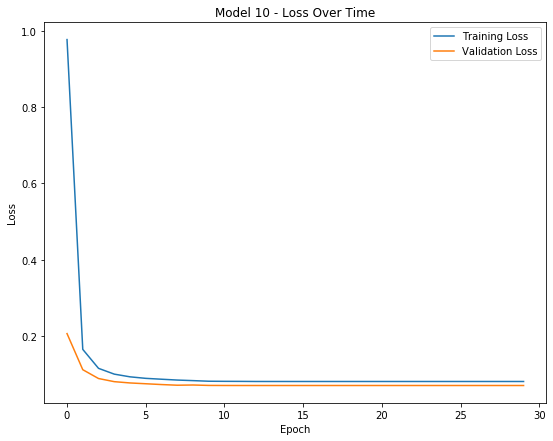

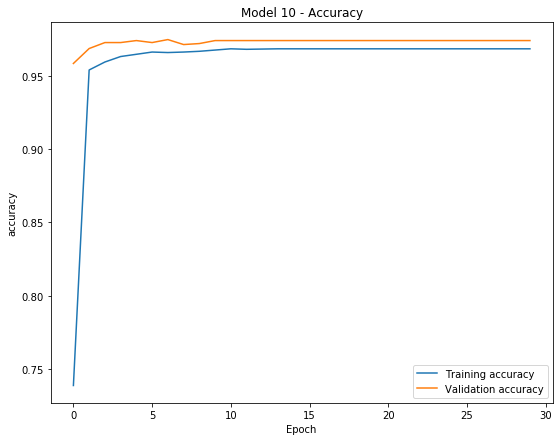

[0.7386499, 0.95408946, 0.9595307, 0.96327156, 0.9648019, 0.96633226, 0.96599215, 0.96633226, 0.96684235, 0.96769255, 0.96854275, 0.9682027, 0.9683727, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275, 0.96854275]
0.96854275


In [50]:
def LDA_MODEL_TRANSFER(trainX, trainY):
    model = Sequential()
    model.add(Input(shape = trainX.shape[1],))
    model.add(Dense(12,activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(16,activation='relu'))
#     model_dimension.add(Dropout(0.5))
#     model_dimension.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='softmax')) 


    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    history = model.fit(
    trainX,
    trainY,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{12}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )

    PLOT(history, 10)

    print(history.history['accuracy'])
    print(max(history.history['accuracy']))

    return model

model_lda = LDA_MODEL_TRANSFER(pd.DataFrame(X_train_lda), y_train)

In [51]:
model_lda = tf.keras.models.load_model('model_12.h5')


model_lda.pop()
model_lda.trainable = False

model_lda.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                72        
Total params: 222
Trainable params: 150
Non-trainable params: 72
_________________________________________________________________


In [36]:
# X_test_real, y_test_real = data('X.csv', 'Y.csv', 'Real-Time')
X, y = data('X.csv', 'Y.csv', 'Real-time_v1')
y -= 1


X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X, y, test_size=0.33, random_state=42)


# #LDA
X_train_real = lda.transform(X_train_real.iloc[:,most_important])
X_test_real = lda.transform(X_test_real.iloc[:,most_important])

X_train_real = model_lda.predict(X_train_real)
X_test_real = model_lda.predict(X_test_real)


X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape

((176, 16), (88, 16), (176, 1), (88, 1))

# SVM

71.67999999999999 Recall
71.99 pre
71.61 fscore
Accuracy is:  0.7272727272727273


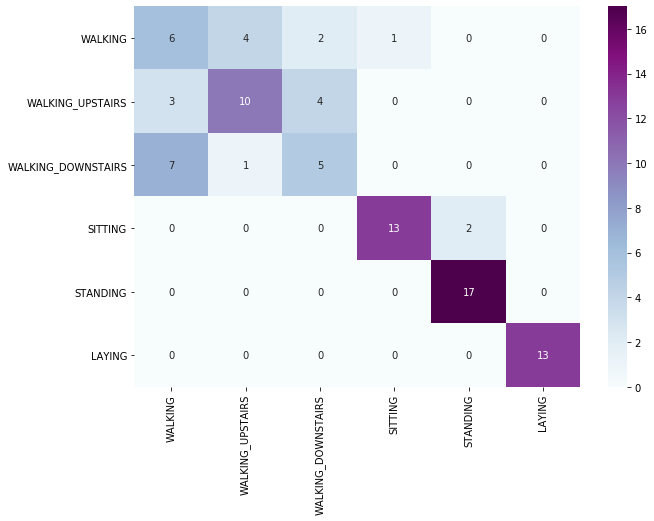

In [37]:
svm = SVC(C = 10, gamma = 0.01, kernel= 'rbf')
check(svm, X_train_real, y_train_real, X_test_real, y_test_real)

In [38]:
# saveModel('PCA/svm_PCA_91', svm)

66.58 Recall
68.78999999999999 pre
66.05 fscore
Accuracy is:  0.6590909090909091


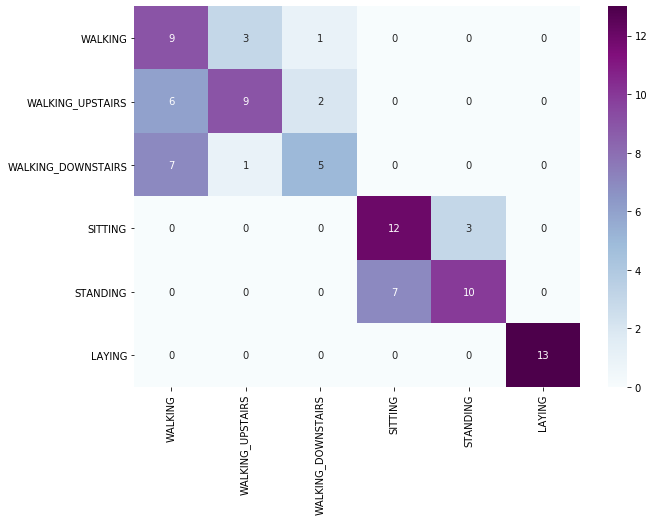

In [39]:
svm = SVC(C = 0.001, gamma = 1, kernel= 'poly')
check(svm, X_train_real, y_train_real, X_test_real, y_test_real)

# saveModel('LDA/svm_LDA_68.1', svm)

In [40]:
def svc_param_selection(X_train_real, y_train_real, nfolds):

    param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1], 
                  'gamma' : [0.01, 0.1, 1], 
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }


    grid_search = GridSearchCV( SVC(), 
                             param_grid, 
                             cv = nfolds,
                             n_jobs = -1) # use all processor
    grid_search.fit(X, y.ravel())

    return grid_search.best_params_

svc_param_selection(X_train_real, y_train_real, 5)

{'C': 0.0001, 'gamma': 1, 'kernel': 'poly'}

# KNN

72.16 Recall
72.37 pre
71.92 fscore
Accuracy is:  0.7272727272727273


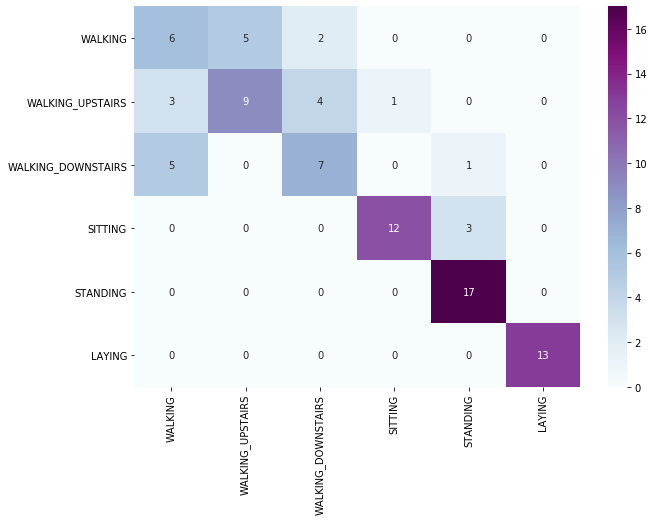

In [41]:
knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors = 5, weights = 'distance')
check(knn, X_train_real, y_train_real, X_test_real, y_test_real)

In [42]:
# saveModel('LDA/knn_LDA_63.6', knn)

In [43]:
def knn_param_selection(X, y, nfolds):

    param_grid = {'n_neighbors' : [3,5,7,11,13,15,19,21],
                'weights' : ['uniform', 'distance'], 
                'metric' : ['euclidean','manhattan'] }

    grid_search = GridSearchCV(KNeighborsClassifier(), 
                             param_grid, 
                             cv = nfolds,
                             n_jobs = -1)

    grid_search.fit(X,y)

    return grid_search.best_params_
                  
# knn_param_selection(X, y.ravel(), 5)

# Random Forest

67.88 Recall
69.17999999999999 pre
67.94 fscore
Accuracy is:  0.6931818181818182


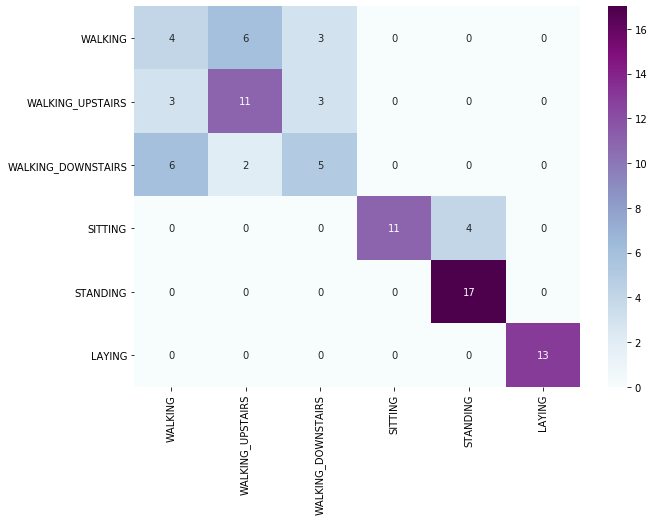

In [48]:
rf = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 6, n_estimators = 30)
check(rf, X_train_real, y_train_real, X_test_real, y_test_real)

In [49]:
saveModel('LDA/rf_LDA_71.5_CHECK', rf)

75.91 Recall
76.01 pre
75.78 fscore
Accuracy is:  0.7727272727272727


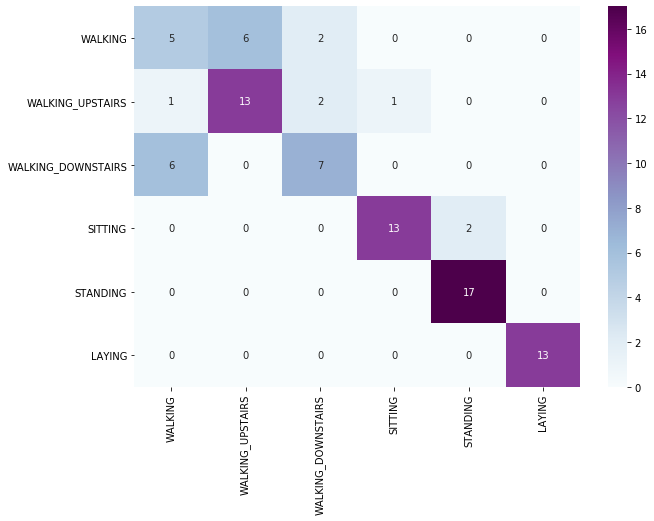

In [46]:
rf = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 6, n_estimators = 40)
check(rf, X_train_real, y_train_real, X_test_real, y_test_real)

In [ ]:
def rf_param_selection(X, y, nfolds):
    param_grid = {'n_estimators': [40, 50, 150],
                'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
                'min_samples_split': [4, 6,8, 10]}

    grid_search = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             cv = nfolds,
                             n_jobs = -1)
    grid_search.fit(X, y)

    return grid_search.best_params_

# knn_param_selection(X, y.ravel(), 5)

rf_param_selection(X, y.ravel(), 5)

# LSTM

In [41]:
X_train_lstm = np.reshape(X_train_real, (X_train_real.shape[0], 1, X_train_real.shape[1]))
X_test_lstm = np.reshape(X_test_real, (X_test_real.shape[0], 1, X_test_real.shape[1]))

In [44]:
def LSTM_Model(trainX, trainY, testX, testY):
    n_steps = 64
    n_feature = 1
    verbose, epochs, batch_size = 0, 50, 64

    lstm = Sequential()
    lstm.add(LSTM(units= trainX.shape[0], input_shape=(n_feature, n_steps) ))
    lstm.add(Dense(128, activation='relu'))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(64, activation='relu'))
#     lstm.add(Dropout(0.2))
#     lstm.add(Dense(64, activation='relu'))
    lstm.add(Dense(6, activation='softmax'))

    print(lstm.summary())

    lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    lstm.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)


    _, accuracy = lstm.evaluate(testX, testY, batch_size=batch_size, verbose=0)
    
    y_pred = lstm.predict(testX)
    y_pred = np.argmax(y_pred,axis=1)
    
    recall = metrics.recall_score(testY, y_pred, average='macro' )
    precision = metrics.precision_score(testY, y_pred, average='macro' )
    f_score = metrics.f1_score(testY, y_pred, average="macro") 

    print(round(recall,4) * 100, 'Recall')
    print(round(precision, 4)*100, 'pre')
    print(round(f_score, 4)*100, "fscore")
    print('Accuracy is: ', metrics.accuracy_score(testY, y_pred))
    
    array = confusion_matrix(testY, y_pred)
    
    df_cm = pd.DataFrame(array, index = [i for i in LABELS],
                    columns = [i for i in LABELS])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="BuPu",fmt='g')

    return accuracy, lstm


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 176)               169664    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               22656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 200,966
Trainable params: 200,966
Non-trainable params: 0
_________________________________________________________________
None
92.10000000000001 Recall
92.14 pre
92.01 fscore
Accuracy is:  0.9204545454545454


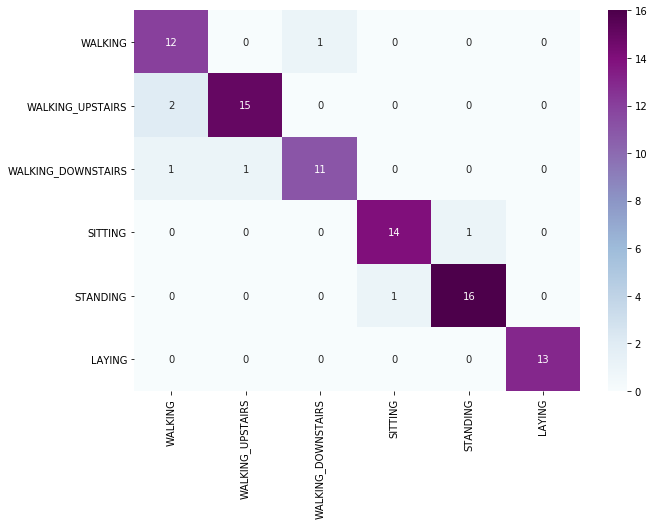

In [45]:
accuracy, lstm = LSTM_Model(X_train_lstm, y_train_real, X_test_lstm, y_test_real )

In [ ]:
from keras.models import load_model

# lstm.save('Models/LDA/lstm_LDA_70.h5')
